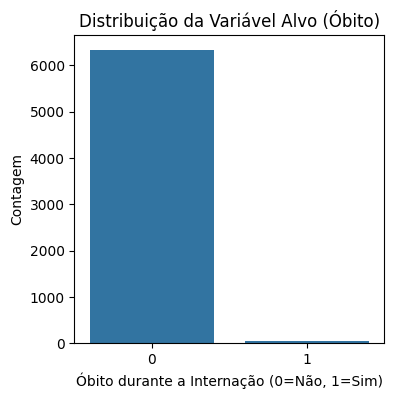

Dimensões de X_train: (4471, 53)
Dimensões de X_test: (1917, 53)
Dimensões de y_train: (4471,)
Dimensões de y_test: (1917,)


/home/rafaelalvestech/.pyenv/versions/3.11.8/envs/vitaldb/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Dimensões de X_train_res: (8862, 53)
Dimensões de y_train_res: (8862,)
Treinando XGBoost...


/home/rafaelalvestech/.pyenv/versions/3.11.8/envs/vitaldb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:51:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rafaelalvestech/.pyenv/versions/3.11.8/envs/vitaldb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:51:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rafaelalvestech/.pyenv/versions/3.11.8/envs/vitaldb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:51:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rafaelalvestech/.pyenv/versions/3.11.8/envs/vitaldb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:51:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarni


=== Resultados do XGBoost ===
  AUC: 0.7253
  F1-Score: 0.2759
  Acurácia: 0.9890
  Tempo de Treinamento: 1019.29 segundos
  Matriz de Confusão:
     1892   8
      13   4

Tempo total: 1019.88 segundos


In [3]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.impute import SimpleImputer

# Registrar o tempo de início do script
start_time = time.time()

# *** 1. Carregamento de Dados ***
df = pd.read_csv('../discrete-data/csv/clinical_data.csv')

# *** 2. Pré-processamento ***
df['sex'] = (df['sex'] == 'M').astype(int)
df['death_inhosp'] = df['death_inhosp'].astype(int)
df.drop(columns=['department', 'optype', 'dx', 'opname', 'approach', 'position',
                  'ane_type', 'cormack', 'airway', 'tubesize', 'dltubesize',
                  'lmasize', 'preop_ecg', 'preop_pft', 'iv1', 'iv2', 'aline1',
                  'aline2', 'cline1', 'cline2'], inplace=True)

# *** Análise Exploratória de Dados (EDA) ***
plt.figure(figsize=(4, 4))
sns.countplot(x='death_inhosp', data=df)
plt.title('Distribuição da Variável Alvo (Óbito)')
plt.xlabel('Óbito durante a Internação (0=Não, 1=Sim)')
plt.ylabel('Contagem')
plt.show()

# Separar recursos e variável alvo
X = df.drop('death_inhosp', axis=1)
y = df['death_inhosp']

# Dividir dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Dimensões de X_train:", X_train.shape)
print("Dimensões de X_test:", X_test.shape)
print("Dimensões de y_train:", y_train.shape)
print("Dimensões de y_test:", y_test.shape)

# *** 3. Tratamento de Valores Ausentes e Conversão de ">89" ***
numeric_columns = X_train.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
X_train[numeric_columns] = imputer.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = imputer.transform(X_test[numeric_columns])

# Converter ">89" para 90 na coluna "age"
X_train['age'] = X_train['age'].replace('>89', 90).astype(float)
X_test['age'] = X_test['age'].replace('>89', 90).astype(float)

# *** 4. Reamostragem ***
sm = SMOTE(random_state=42, k_neighbors=3, n_jobs=-1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = undersampler.fit_resample(X_train_res, y_train_res)

# Verifique o formato dos arrays após a reamostragem
print("Dimensões de X_train_res:", X_train_res.shape)
print("Dimensões de y_train_res:", y_train_res.shape)

# Corrija o formato se necessário
if len(X_train_res.shape) == 1:
  X_train_res = X_train_res.reshape(-1, 1)
if len(y_train_res.shape) == 1:
  # Converte y_train_res para um array NumPy antes de usar reshape
  y_train_res = np.array(y_train_res).reshape(-1, 1)

# *** 5. Definição dos Modelos e Hiperparâmetros ***
model = xgb.XGBClassifier(objective="binary:logistic", 
                                    random_state=42,
                                    n_jobs=-1,
                                    tree_method='hist',  # Mude para 'hist' para usar CPU
                                    predictor='cpu_predictor')  # Mude para 'cpu_predictor' para usar CPU

param_grid = {'max_depth': [5, 10],  
                 'learning_rate': [0.01, 0.05, 0.1], 
                 'subsample': [0.7, 0.8, 1],
                 'colsample_bytree': [0.7, 0.8, 1], 
                 'gamma': [0, 1, 5],
                 'min_child_weight': [1, 5, 10], 
                 'scale_pos_weight': [1, 5, 10]} 


# *** 6. Treinamento e Avaliação dos Modelos ***
print(f"Treinando XGBoost...")
inicio_modelo = time.time()

# Criar modelo usando GridSearchCV
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                                    cv=stratified_cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Avaliação do modelo
auroc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tempo_modelo = time.time() - inicio_modelo
results = {'AUC': auroc, 'F1': f1, 'Acurácia': acc,
                            'Tempo': tempo_modelo,
                            'Matriz de Confusão': (tn, fp, fn, tp)}

print(f"\n=== Resultados do XGBoost ===")
print(f"  AUC: {auroc:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Acurácia: {acc:.4f}")
print(f"  Tempo de Treinamento: {tempo_modelo:.2f} segundos")
print("  Matriz de Confusão:")
print("     {:>3}  {:>2}".format(tn, fp))
print("     {:>3}  {:>2}".format(fn, tp))

print(f"\nTempo total: {time.time() - start_time:.2f} segundos")
